<a href="https://colab.research.google.com/github/ilyaleonovStudy/test/blob/main/LR_1_Variant3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №1
## Регрессионный анализ данных на основе нейросетевых моделей

**Вариант 3**
- Набор данных: прибыль стартапов в зависимости от трех типов расходов
- Целевой признак: Profit (прибыль стартапа)
- Пункт 5: LSTM рекуррентная сеть
- Пункт 3.h: Нормализация

---

## 1. Загрузка необходимых пакетов и библиотек

In [1]:
# Установка необходимых пакетов (для Colab) - если потребуется
# Все основные библиотеки уже установлены в Colab

In [2]:
# Основные библиотеки
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - препроцессинг и метрики
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Для загрузки файлов в Colab
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Установка seed для воспроизводимости
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Запуск в Google Colab: {IN_COLAB}")

NumPy version: 2.0.2
Pandas version: 2.2.2
TensorFlow version: 2.19.0
Запуск в Google Colab: True


## 2. Загрузка данных

In [3]:
# Загрузка данных через кнопку (для Google Colab)
if IN_COLAB:
    print("=" * 60)
    print("Нажмите кнопку ниже для загрузки файла 50_Startups.csv:")
    print("=" * 60)
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(filename)
else:
    # Локальная загрузка (для тестирования вне Colab)
    df = pd.read_csv('50_Startups.csv')

print(f"\n✓ Данные успешно загружены!")
print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")

Нажмите кнопку ниже для загрузки файла 50_Startups.csv:


Saving 50_Startups.csv to 50_Startups.csv

✓ Данные успешно загружены!
Размер датасета: 50 строк, 5 столбцов


## 3. Разведочный анализ данных (EDA)

### 3.a Ознакомление с данными с помощью методов описательной статистики

In [4]:
# Первые 10 записей
print("=" * 60)
print("ПЕРВЫЕ 10 ЗАПИСЕЙ ДАТАСЕТА")
print("=" * 60)
df.head(10)

ПЕРВЫЕ 10 ЗАПИСЕЙ ДАТАСЕТА


,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94
5,131876.90,99814.71,362861.36,New York,156991.12
6,134615.46,147198.87,127716.82,California,156122.51
7,130298.13,145530.06,323876.68,Florida,155752.60
8,120542.52,148718.95,311613.29,New York,152211.77
9,123334.88,108679.17,304981.62,California,149759.96


In [5]:
# Информация о датасете
print("=" * 60)
print("ИНФОРМАЦИЯ О ДАТАСЕТЕ")
print("=" * 60)
print(f"\nРазмерность данных: {df.shape}")
print(f"\nТипы данных:")
print(df.dtypes)
print(f"\nОбщая информация:")
df.info()

ИНФОРМАЦИЯ О ДАТАСЕТЕ

Размерность данных: (50, 5)

Типы данных:
R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [6]:
# Описательная статистика для числовых признаков
print("=" * 60)
print("ОПИСАТЕЛЬНАЯ СТАТИСТИКА (ЧИСЛОВЫЕ ПРИЗНАКИ)")
print("=" * 60)
df.describe().round(2)

ОПИСАТЕЛЬНАЯ СТАТИСТИКА (ЧИСЛОВЫЕ ПРИЗНАКИ)


,R&D Spend,Administration,Marketing Spend,Profit
count,50.00,50.00,50.00,50.00
mean,73721.62,121344.64,211025.10,112012.64
std,45902.26,28017.80,122290.31,40306.18
min,0.00,51283.14,0.00,14681.40
25%,39936.37,103730.88,129300.13,90138.90
50%,73051.08,122699.80,212716.24,107978.19
75%,101602.80,144842.18,299469.08,139765.98
max,165349.20,182645.56,471784.10,192261.83


In [7]:
# Статистика для категориального признака
print("=" * 60)
print("АНАЛИЗ КАТЕГОРИАЛЬНОГО ПРИЗНАКА 'State'")
print("=" * 60)
print(f"\nУникальные значения: {df['State'].unique()}")
print(f"\nКоличество уникальных значений: {df['State'].nunique()}")
print(f"\nРаспределение по штатам:")
print(df['State'].value_counts())

АНАЛИЗ КАТЕГОРИАЛЬНОГО ПРИЗНАКА 'State'

Уникальные значения: ['New York' 'California' 'Florida']

Количество уникальных значений: 3

Распределение по штатам:
State
New York      17
California    17
Florida       16
Name: count, dtype: int64


In [8]:
# Проверка на пропущенные значения и дубликаты
print("=" * 60)
print("ПРОВЕРКА НА ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ И ДУБЛИКАТЫ")
print("=" * 60)

missing = df.isnull().sum()
print("\nПропущенные значения по столбцам:")
print(missing)
print(f"\nОбщее количество пропусков: {missing.sum()}")

duplicates = df.duplicated().sum()
print(f"\nКоличество дубликатов: {duplicates}")

if missing.sum() == 0 and duplicates == 0:
    print("\n✓ Данные чистые: пропуски и дубликаты отсутствуют!")

ПРОВЕРКА НА ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ И ДУБЛИКАТЫ

Пропущенные значения по столбцам:
R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

Общее количество пропусков: 0

Количество дубликатов: 0

✓ Данные чистые: пропуски и дубликаты отсутствуют!


### 3.b Визуализация данных

#### Одномерная визуализация (распределение признаков)

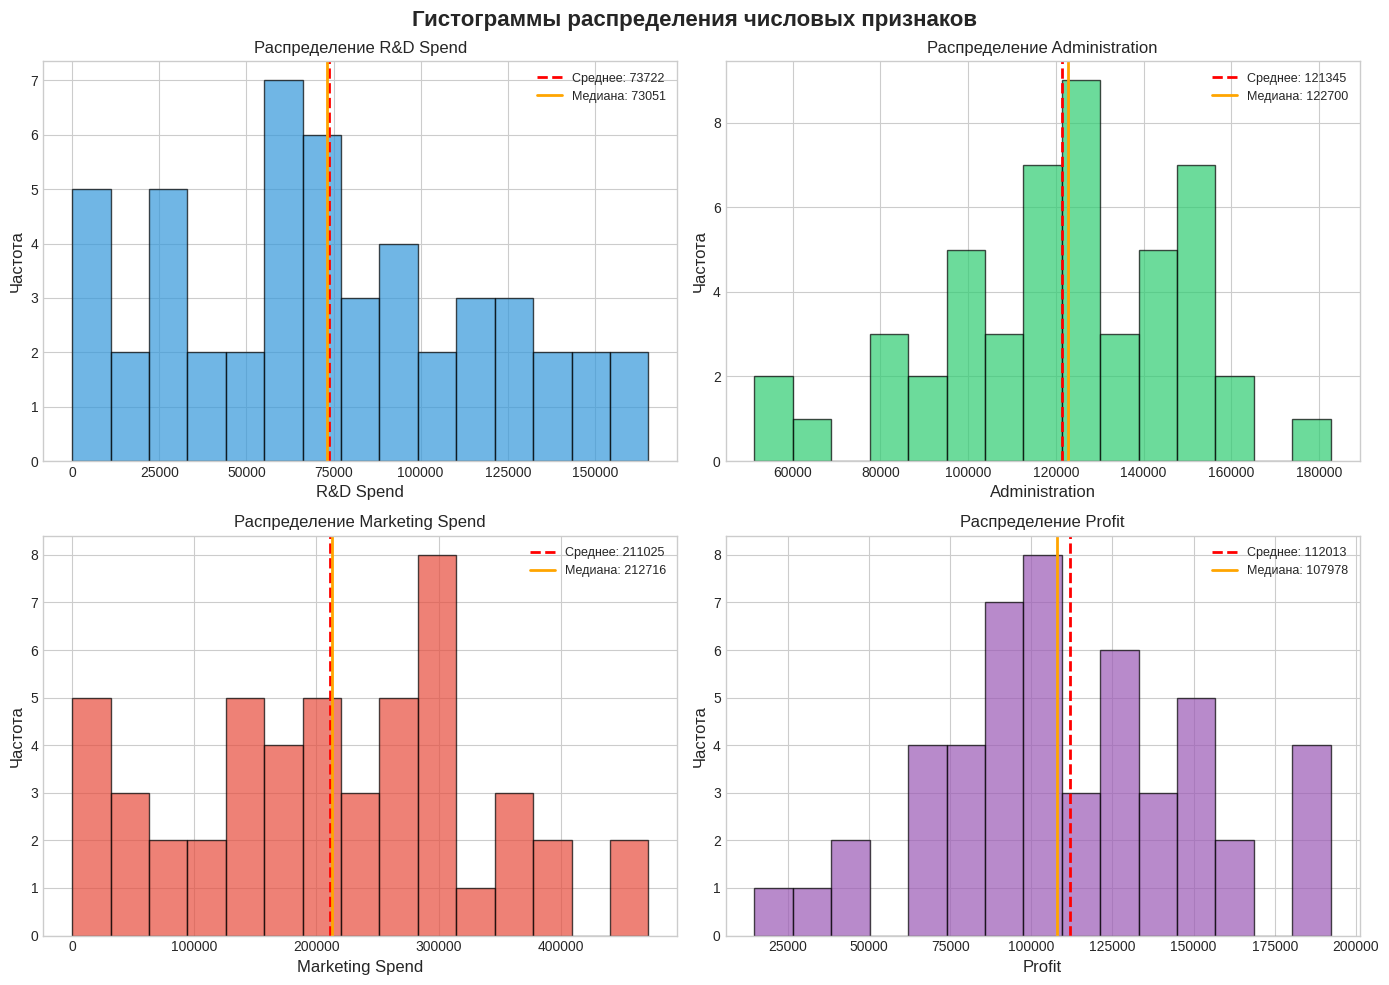

In [9]:
# Гистограммы распределения числовых признаков
numeric_cols = ['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Гистограммы распределения числовых признаков', fontsize=16, fontweight='bold')

colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for idx, (col, ax) in enumerate(zip(numeric_cols, axes.flat)):
    ax.hist(df[col], bins=15, color=colors[idx], edgecolor='black', alpha=0.7)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Частота', fontsize=12)
    ax.set_title(f'Распределение {col}', fontsize=12)
    ax.axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Среднее: {df[col].mean():.0f}')
    ax.axvline(df[col].median(), color='orange', linestyle='-', linewidth=2, label=f'Медиана: {df[col].median():.0f}')
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

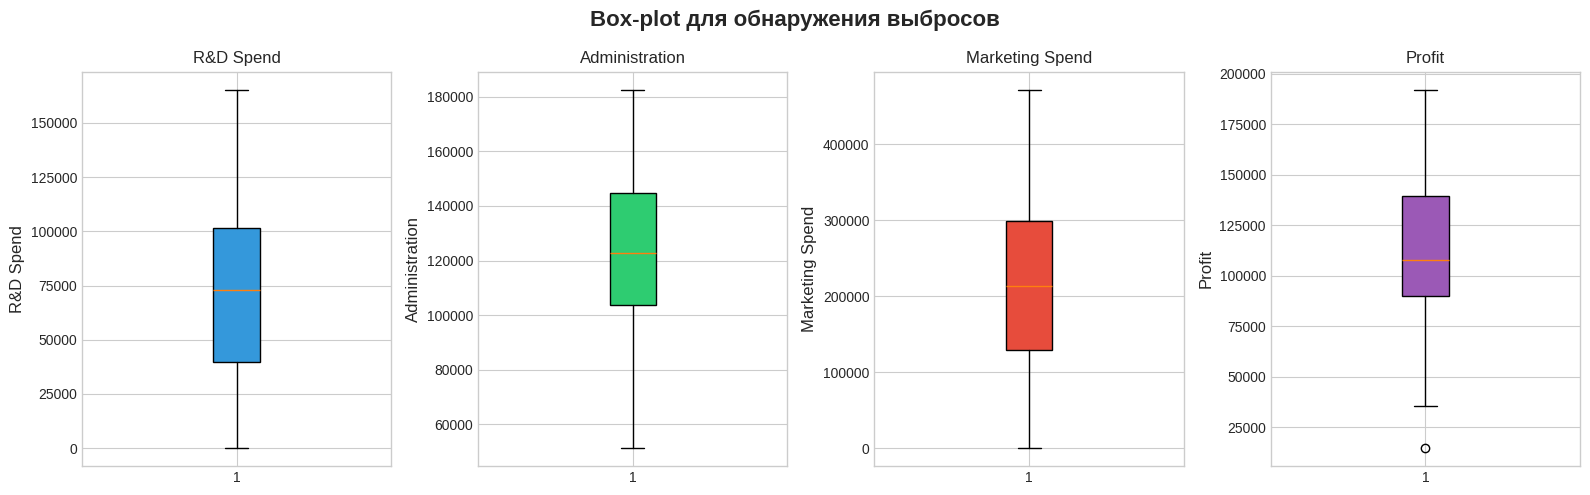

In [10]:
# Box-plot для обнаружения выбросов
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
fig.suptitle('Box-plot для обнаружения выбросов', fontsize=16, fontweight='bold')

for idx, (col, ax) in enumerate(zip(numeric_cols, axes.flat)):
    box = ax.boxplot(df[col], patch_artist=True)
    box['boxes'][0].set_facecolor(colors[idx])
    ax.set_ylabel(col, fontsize=12)
    ax.set_title(col, fontsize=12)

plt.tight_layout()
plt.show()

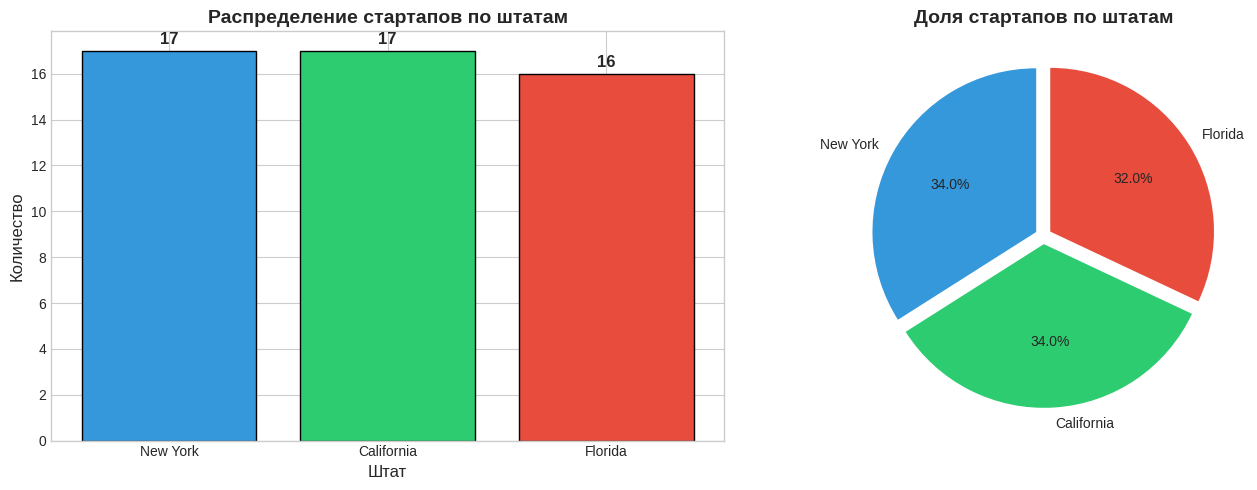

In [11]:
# Распределение категориального признака State
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Столбчатая диаграмма
state_counts = df['State'].value_counts()
axes[0].bar(state_counts.index, state_counts.values, color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black')
axes[0].set_xlabel('Штат', fontsize=12)
axes[0].set_ylabel('Количество', fontsize=12)
axes[0].set_title('Распределение стартапов по штатам', fontsize=14, fontweight='bold')
for i, v in enumerate(state_counts.values):
    axes[0].text(i, v + 0.3, str(v), ha='center', fontsize=12, fontweight='bold')

# Круговая диаграмма
axes[1].pie(state_counts.values, labels=state_counts.index, autopct='%1.1f%%',
            colors=['#3498db', '#2ecc71', '#e74c3c'], startangle=90,
            explode=(0.05, 0.05, 0.05))
axes[1].set_title('Доля стартапов по штатам', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

#### Многомерная визуализация (зависимости между признаками)

Построение матрицы рассеяния (pairplot)...


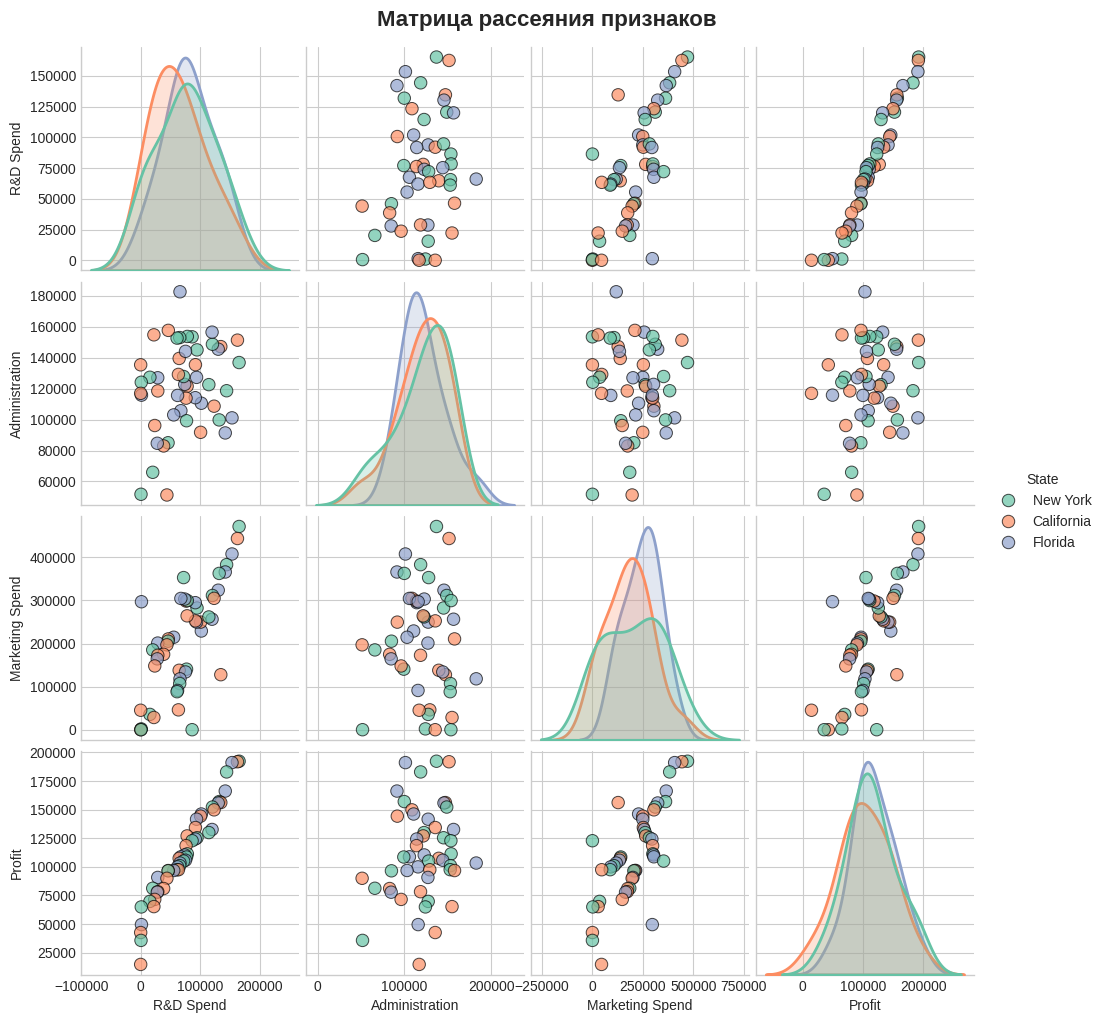

In [12]:
# Pairplot - попарные зависимости
print("Построение матрицы рассеяния (pairplot)...")
sns.pairplot(df, hue='State', palette='Set2', diag_kind='kde',
             plot_kws={'alpha': 0.7, 's': 80, 'edgecolor': 'black'},
             diag_kws={'linewidth': 2})
plt.suptitle('Матрица рассеяния признаков', y=1.02, fontsize=16, fontweight='bold')
plt.show()

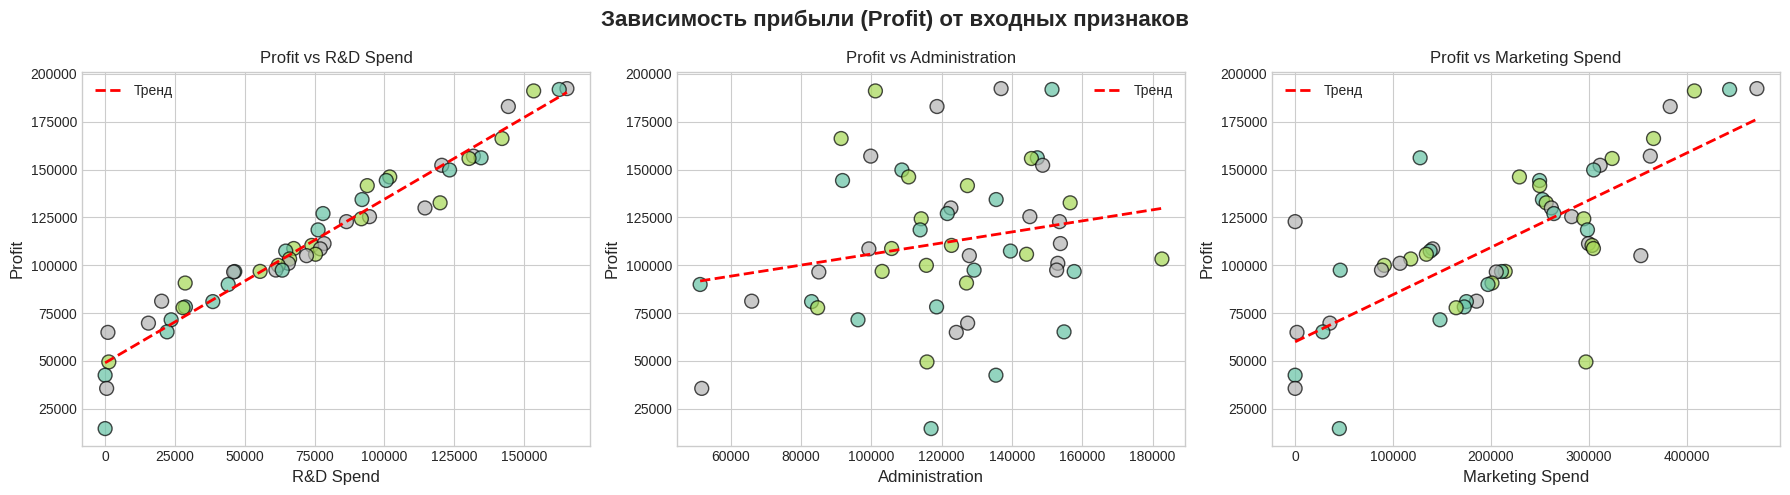

In [13]:
# Зависимость Profit от каждого признака
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Зависимость прибыли (Profit) от входных признаков', fontsize=16, fontweight='bold')

input_features = ['R&D Spend', 'Administration', 'Marketing Spend']

for idx, (col, ax) in enumerate(zip(input_features, axes.flat)):
    scatter = ax.scatter(df[col], df['Profit'], c=df['State'].astype('category').cat.codes,
                         cmap='Set2', alpha=0.7, s=100, edgecolor='black')
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Profit', fontsize=12)
    ax.set_title(f'Profit vs {col}', fontsize=12)

    # Линия тренда
    z = np.polyfit(df[col], df['Profit'], 1)
    p = np.poly1d(z)
    ax.plot(df[col].sort_values(), p(df[col].sort_values()), "r--", linewidth=2, label='Тренд')
    ax.legend()

plt.tight_layout()
plt.show()

### 3.c Очистка данных

In [14]:
# Проверка на выбросы методом IQR
print("=" * 60)
print("АНАЛИЗ ВЫБРОСОВ (МЕТОД IQR)")
print("=" * 60)

def detect_outliers_iqr(data, column):
    """Обнаружение выбросов методом межквартильного размаха"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

for col in numeric_cols:
    outliers, lb, ub = detect_outliers_iqr(df, col)
    print(f"\n{col}:")
    print(f"  Границы: [{lb:.2f}, {ub:.2f}]")
    print(f"  Количество выбросов: {len(outliers)}")

print("\n" + "=" * 60)
print("✓ Данные не требуют очистки - выбросы отсутствуют или незначительны")
print("=" * 60)

АНАЛИЗ ВЫБРОСОВ (МЕТОД IQR)

R&D Spend:
  Границы: [-52563.28, 194102.45]
  Количество выбросов: 0

Administration:
  Границы: [42063.92, 206509.14]
  Количество выбросов: 0

Marketing Spend:
  Границы: [-125953.30, 554722.51]
  Количество выбросов: 0

Profit:
  Границы: [15698.29, 214206.59]
  Количество выбросов: 1

✓ Данные не требуют очистки - выбросы отсутствуют или незначительны


### 3.d Корреляционный анализ

КОРРЕЛЯЦИОННАЯ МАТРИЦА
                 R&D Spend  Administration  Marketing Spend  Profit
R&D Spend            1.000           0.242            0.724   0.973
Administration       0.242           1.000           -0.032   0.201
Marketing Spend      0.724          -0.032            1.000   0.748
Profit               0.973           0.201            0.748   1.000


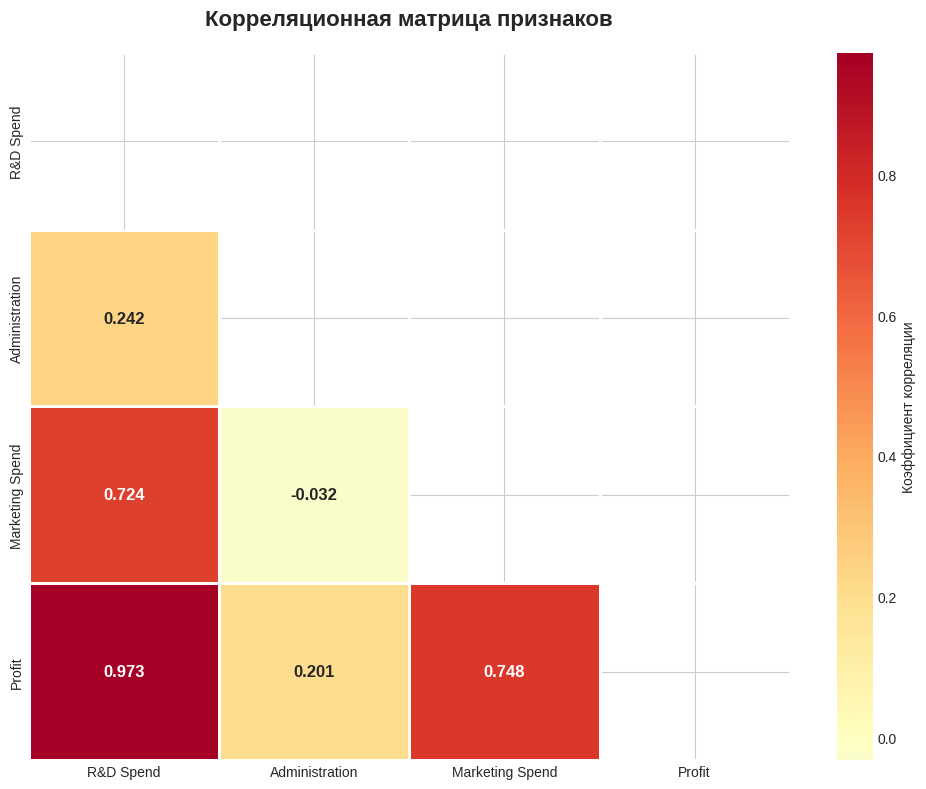

In [15]:
# Корреляционная матрица
print("=" * 60)
print("КОРРЕЛЯЦИОННАЯ МАТРИЦА")
print("=" * 60)

correlation_matrix = df[numeric_cols].corr()
print(correlation_matrix.round(3))

# Визуализация корреляционной матрицы
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
            fmt='.3f', linewidths=2, mask=mask, ax=ax,
            annot_kws={'fontsize': 12, 'fontweight': 'bold'},
            cbar_kws={'label': 'Коэффициент корреляции'})
ax.set_title('Корреляционная матрица признаков', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

КОРРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Profit)
R&D Spend          0.973
Marketing Spend    0.748
Administration     0.201
Name: Profit, dtype: float64


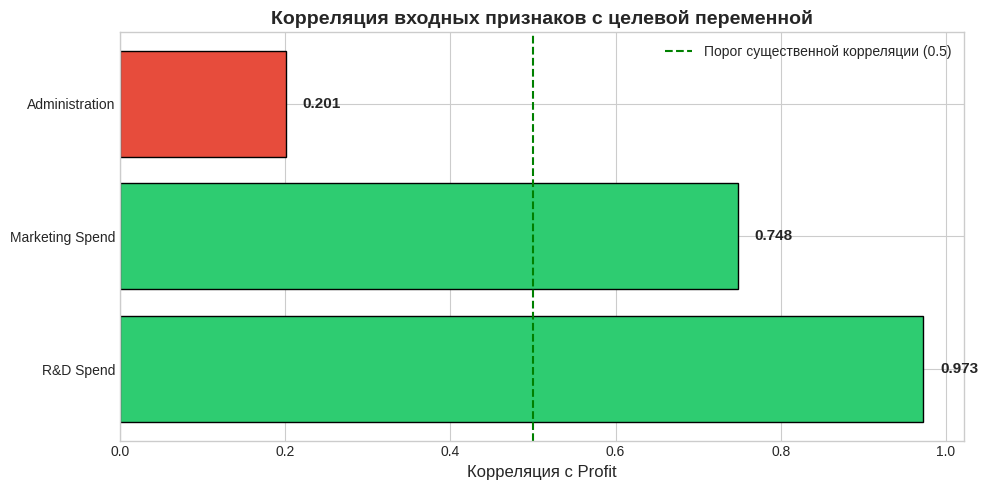


ВЫВОДЫ ПО КОРРЕЛЯЦИОННОМУ АНАЛИЗУ:
• R&D Spend имеет ОЧЕНЬ СИЛЬНУЮ положительную корреляцию с Profit (0.973)
• Marketing Spend имеет УМЕРЕННУЮ положительную корреляцию (0.748)
• Administration имеет СЛАБУЮ корреляцию (0.201)
• R&D Spend - наиболее важный признак для предсказания прибыли


In [16]:
# Корреляция с целевой переменной
print("=" * 60)
print("КОРРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Profit)")
print("=" * 60)

target_corr = correlation_matrix['Profit'].drop('Profit').sort_values(ascending=False)
print(target_corr.round(3))

# Визуализация
fig, ax = plt.subplots(figsize=(10, 5))
colors_corr = ['#2ecc71' if x > 0.5 else '#f1c40f' if x > 0.3 else '#e74c3c' for x in target_corr.values]
bars = ax.barh(target_corr.index, target_corr.values, color=colors_corr, edgecolor='black')
ax.set_xlabel('Корреляция с Profit', fontsize=12)
ax.set_title('Корреляция входных признаков с целевой переменной', fontsize=14, fontweight='bold')
ax.axvline(x=0.5, color='green', linestyle='--', label='Порог существенной корреляции (0.5)')
ax.legend()

for bar, val in zip(bars, target_corr.values):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
            va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("ВЫВОДЫ ПО КОРРЕЛЯЦИОННОМУ АНАЛИЗУ:")
print("=" * 60)
print("• R&D Spend имеет ОЧЕНЬ СИЛЬНУЮ положительную корреляцию с Profit (0.973)")
print("• Marketing Spend имеет УМЕРЕННУЮ положительную корреляцию (0.748)")
print("• Administration имеет СЛАБУЮ корреляцию (0.201)")
print("• R&D Spend - наиболее важный признак для предсказания прибыли")

### 3.e Эксперименты с комбинациями атрибутов

In [17]:
# Создание новых признаков
print("=" * 60)
print("СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ")
print("=" * 60)

# Копия датафрейма для экспериментов
df_extended = df.copy()

# Новые признаки
df_extended['Total_Spend'] = df_extended['R&D Spend'] + df_extended['Administration'] + df_extended['Marketing Spend']
df_extended['RD_to_Total'] = df_extended['R&D Spend'] / (df_extended['Total_Spend'] + 1e-10)
df_extended['Marketing_to_Total'] = df_extended['Marketing Spend'] / (df_extended['Total_Spend'] + 1e-10)
df_extended['RD_Marketing_Ratio'] = df_extended['R&D Spend'] / (df_extended['Marketing Spend'] + 1e-10)

print("Созданные признаки:")
print("1. Total_Spend = R&D + Administration + Marketing")
print("2. RD_to_Total = R&D Spend / Total_Spend")
print("3. Marketing_to_Total = Marketing Spend / Total_Spend")
print("4. RD_Marketing_Ratio = R&D Spend / Marketing Spend")

# Корреляция новых признаков с Profit
new_features = ['Total_Spend', 'RD_to_Total', 'Marketing_to_Total', 'RD_Marketing_Ratio']
new_corr = df_extended[new_features + ['Profit']].corr()['Profit'].drop('Profit')

print("\nКорреляция новых признаков с Profit:")
print(new_corr.sort_values(ascending=False).round(3))

СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ
Созданные признаки:
1. Total_Spend = R&D + Administration + Marketing
2. RD_to_Total = R&D Spend / Total_Spend
3. Marketing_to_Total = Marketing Spend / Total_Spend
4. RD_Marketing_Ratio = R&D Spend / Marketing Spend

Корреляция новых признаков с Profit:
Total_Spend           0.873
RD_to_Total           0.772
Marketing_to_Total    0.434
RD_Marketing_Ratio    0.037
Name: Profit, dtype: float64


### 3.f Отбор существенных признаков

In [18]:
# Отбор признаков на основе корреляции
print("=" * 60)
print("ОТБОР СУЩЕСТВЕННЫХ ПРИЗНАКОВ")
print("=" * 60)

# Порог существенной корреляции
CORRELATION_THRESHOLD = 0.5

# Все числовые признаки с корреляцией
all_features_corr = df_extended.drop(['State', 'Profit'], axis=1).corrwith(df_extended['Profit']).abs()
print(f"\nВсе признаки и их корреляция с Profit:")
print(all_features_corr.sort_values(ascending=False).round(3))

# Существенные признаки (корреляция > порога)
significant_features = all_features_corr[all_features_corr > CORRELATION_THRESHOLD].index.tolist()
print(f"\n✓ Существенные признаки (корреляция > {CORRELATION_THRESHOLD}):")
print(significant_features)

# Для построенного набора данных используем только существенные оригинальные признаки
original_significant = ['R&D Spend', 'Marketing Spend']
print(f"\n✓ Отобранные существенные признаки для построенного набора:")
print(original_significant)

ОТБОР СУЩЕСТВЕННЫХ ПРИЗНАКОВ

Все признаки и их корреляция с Profit:
R&D Spend             0.973
Total_Spend           0.873
RD_to_Total           0.772
Marketing Spend       0.748
Marketing_to_Total    0.434
Administration        0.201
RD_Marketing_Ratio    0.037
dtype: float64

✓ Существенные признаки (корреляция > 0.5):
['R&D Spend', 'Marketing Spend', 'Total_Spend', 'RD_to_Total']

✓ Отобранные существенные признаки для построенного набора:
['R&D Spend', 'Marketing Spend']


### 3.g Преобразование категориальных признаков

In [19]:
# One-Hot Encoding для признака State
print("=" * 60)
print("ПРЕОБРАЗОВАНИЕ КАТЕГОРИАЛЬНОГО ПРИЗНАКА (One-Hot Encoding)")
print("=" * 60)

# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['State'], prefix='State', drop_first=False)

print("\nИсходные столбцы:")
print(df.columns.tolist())

print("\nСтолбцы после One-Hot Encoding:")
print(df_encoded.columns.tolist())

print("\nПример данных после кодирования:")
df_encoded.head()

ПРЕОБРАЗОВАНИЕ КАТЕГОРИАЛЬНОГО ПРИЗНАКА (One-Hot Encoding)

Исходные столбцы:
['R&D Spend', 'Administration', 'Marketing Spend', 'State', 'Profit']

Столбцы после One-Hot Encoding:
['R&D Spend', 'Administration', 'Marketing Spend', 'Profit', 'State_California', 'State_Florida', 'State_New York']

Пример данных после кодирования:


,R&D Spend,Administration,Marketing Spend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.80,471784.10,192261.83,False,False,True
1,162597.70,151377.59,443898.53,191792.06,True,False,False
2,153441.51,101145.55,407934.54,191050.39,False,True,False
3,144372.41,118671.85,383199.62,182901.99,False,False,True
4,142107.34,91391.77,366168.42,166187.94,False,True,False


### 3.h Нормализация данных (по варианту)

In [20]:
# Нормализация данных (MinMaxScaler - приводит к диапазону [0, 1])
print("=" * 60)
print("НОРМАЛИЗАЦИЯ ДАННЫХ (MinMaxScaler)")
print("=" * 60)

# Подготовка данных
# Исходный набор (все признаки) - явное преобразование в float32
X_original = df_encoded.drop('Profit', axis=1).astype(np.float32)
y = df_encoded['Profit'].values.astype(np.float32)

# Построенный набор (только существенные признаки)
X_selected = df_encoded[original_significant].astype(np.float32)

print(f"\nИсходный набор признаков: {X_original.columns.tolist()}")
print(f"Построенный набор признаков: {X_selected.columns.tolist()}")

# Скейлеры
scaler_X_original = MinMaxScaler()
scaler_X_selected = MinMaxScaler()
scaler_y = MinMaxScaler()

# Нормализация
X_original_scaled = scaler_X_original.fit_transform(X_original).astype(np.float32)
X_selected_scaled = scaler_X_selected.fit_transform(X_selected).astype(np.float32)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten().astype(np.float32)

print("\n✓ Нормализация выполнена!")
print(f"\nДиапазон X_original до нормализации: [{X_original.values.min():.2f}, {X_original.values.max():.2f}]")
print(f"Диапазон X_original после нормализации: [{X_original_scaled.min():.2f}, {X_original_scaled.max():.2f}]")
print(f"\nДиапазон y до нормализации: [{y.min():.2f}, {y.max():.2f}]")
print(f"Диапазон y после нормализации: [{y_scaled.min():.2f}, {y_scaled.max():.2f}]")

НОРМАЛИЗАЦИЯ ДАННЫХ (MinMaxScaler)

Исходный набор признаков: ['R&D Spend', 'Administration', 'Marketing Spend', 'State_California', 'State_Florida', 'State_New York']
Построенный набор признаков: ['R&D Spend', 'Marketing Spend']

✓ Нормализация выполнена!

Диапазон X_original до нормализации: [0.00, 471784.09]
Диапазон X_original после нормализации: [0.00, 1.00]

Диапазон y до нормализации: [14681.40, 192261.83]
Диапазон y после нормализации: [0.00, 1.00]


## 4. Формирование наборов данных и разбиение на выборки

In [21]:
# Формирование 4 наборов данных
print("=" * 60)
print("ФОРМИРОВАНИЕ 4 НАБОРОВ ДАННЫХ")
print("=" * 60)

datasets = {
    'original': (X_original.values.astype(np.float32), y.astype(np.float32), 'Исходный набор'),
    'original_normalized': (X_original_scaled.astype(np.float32), y_scaled.astype(np.float32), 'Исходный нормализованный'),
    'selected': (X_selected.values.astype(np.float32), y.astype(np.float32), 'Построенный набор'),
    'selected_normalized': (X_selected_scaled.astype(np.float32), y_scaled.astype(np.float32), 'Построенный нормализованный')
}

for key, (X, y_data, name) in datasets.items():
    print(f"\n{name}:")
    print(f"  X shape: {X.shape}, dtype: {X.dtype}")
    print(f"  y shape: {y_data.shape}, dtype: {y_data.dtype}")

ФОРМИРОВАНИЕ 4 НАБОРОВ ДАННЫХ

Исходный набор:
  X shape: (50, 6), dtype: float32
  y shape: (50,), dtype: float32

Исходный нормализованный:
  X shape: (50, 6), dtype: float32
  y shape: (50,), dtype: float32

Построенный набор:
  X shape: (50, 2), dtype: float32
  y shape: (50,), dtype: float32

Построенный нормализованный:
  X shape: (50, 2), dtype: float32
  y shape: (50,), dtype: float32


In [22]:
# Разбиение на train/val/test (60%/20%/20%)
print("=" * 60)
print("РАЗБИЕНИЕ НА ОБУЧАЮЩУЮ, ВАЛИДАЦИОННУЮ И ТЕСТОВУЮ ВЫБОРКИ")
print("=" * 60)

def split_data(X, y, test_size=0.2, val_size=0.25, random_state=SEED):
    """
    Разбиение данных на train/val/test
    test_size=0.2 -> 20% тест
    val_size=0.25 от оставшихся 80% -> 20% val, 60% train
    """
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Словарь для хранения разбитых данных
data_splits = {}

for key, (X, y_data, name) in datasets.items():
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y_data)
    data_splits[key] = {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'name': name
    }
    print(f"\n{name}:")
    print(f"  Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
    print(f"  Val:   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.0f}%)")
    print(f"  Test:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.0f}%)")

РАЗБИЕНИЕ НА ОБУЧАЮЩУЮ, ВАЛИДАЦИОННУЮ И ТЕСТОВУЮ ВЫБОРКИ

Исходный набор:
  Train: 30 samples (60%)
  Val:   10 samples (20%)
  Test:  10 samples (20%)

Исходный нормализованный:
  Train: 30 samples (60%)
  Val:   10 samples (20%)
  Test:  10 samples (20%)

Построенный набор:
  Train: 30 samples (60%)
  Val:   10 samples (20%)
  Test:  10 samples (20%)

Построенный нормализованный:
  Train: 30 samples (60%)
  Val:   10 samples (20%)
  Test:  10 samples (20%)


## 5. Построение и сравнение моделей

### 5.1 Функции для создания моделей и оценки качества

In [23]:
# Функция расчета метрик
def calculate_metrics(y_true, y_pred, scaler=None):
    """Расчет метрик качества регрессии"""
    # Если данные нормализованы, обратное преобразование
    if scaler is not None:
        y_true = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    return {'RMSE': rmse, 'R2': r2, 'MAE': mae}

# Функция создания полносвязной сети (MLP)
def create_mlp_model(input_dim, neurons=64, layers=2, learning_rate=0.001):
    """Создание полносвязной нейронной сети"""
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    for i in range(layers):
        model.add(Dense(neurons // (2**i) if neurons // (2**i) >= 8 else 8, activation='relu'))
        model.add(Dropout(0.2))

    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Функция создания LSTM сети
def create_lstm_model(input_dim, units=64, layers=1, learning_rate=0.001):
    """
    Создание LSTM нейронной сети
    Для табличных данных преобразуем вход в 3D формат (samples, timesteps=1, features)
    """
    model = Sequential()
    model.add(Input(shape=(1, input_dim)))  # timesteps=1, features=input_dim

    for i in range(layers):
        return_sequences = (i < layers - 1)  # True для всех кроме последнего LSTM
        model.add(LSTM(units // (2**i) if units // (2**i) >= 8 else 8,
                       return_sequences=return_sequences))
        model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

print("✓ Функции для создания моделей определены")

✓ Функции для создания моделей определены


In [24]:
# Функция обучения и оценки модели
def train_and_evaluate(model_type, X_train, X_val, y_train, y_val,
                       epochs=200, batch_size=8, verbose=0, is_normalized=False):
    """Обучение и оценка модели"""
    input_dim = X_train.shape[1]

    # Создание модели
    if model_type == 'MLP':
        model = create_mlp_model(input_dim)
        X_train_model = X_train
        X_val_model = X_val
    else:  # LSTM
        model = create_lstm_model(input_dim)
        # Преобразование в 3D для LSTM
        X_train_model = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_val_model = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    # Early Stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=20,
                               restore_best_weights=True, verbose=0)

    # Обучение
    history = model.fit(X_train_model, y_train,
                        validation_data=(X_val_model, y_val),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[early_stop], verbose=verbose)

    # Предсказания
    y_train_pred = model.predict(X_train_model, verbose=0).flatten()
    y_val_pred = model.predict(X_val_model, verbose=0).flatten()

    # Метрики
    scaler = scaler_y if is_normalized else None
    train_metrics = calculate_metrics(y_train, y_train_pred, scaler)
    val_metrics = calculate_metrics(y_val, y_val_pred, scaler)

    return model, history, train_metrics, val_metrics

print("✓ Функция обучения и оценки определена")

✓ Функция обучения и оценки определена


### 5.2 Обучение и сравнение всех моделей

In [25]:
# Обучение всех моделей на всех наборах данных
print("=" * 80)
print("ОБУЧЕНИЕ И СРАВНЕНИЕ МОДЕЛЕЙ")
print("=" * 80)

results = []
models_dict = {}

model_types = ['MLP', 'LSTM']

for dataset_key, data in data_splits.items():
    is_normalized = 'normalized' in dataset_key
    dataset_name = data['name']

    print(f"\n{'='*60}")
    print(f"Набор данных: {dataset_name}")
    print(f"{'='*60}")

    for model_type in model_types:
        print(f"\n  Обучение {model_type}...", end=" ")

        model, history, train_metrics, val_metrics = train_and_evaluate(
            model_type,
            data['X_train'], data['X_val'],
            data['y_train'], data['y_val'],
            is_normalized=is_normalized
        )

        # Сохранение результатов
        result = {
            'Dataset': dataset_name,
            'Model': model_type,
            'Train_RMSE': train_metrics['RMSE'],
            'Train_R2': train_metrics['R2'],
            'Val_RMSE': val_metrics['RMSE'],
            'Val_R2': val_metrics['R2'],
            'Epochs': len(history.history['loss'])
        }
        results.append(result)

        # Сохранение модели
        models_dict[f"{dataset_key}_{model_type}"] = {
            'model': model,
            'history': history,
            'is_normalized': is_normalized
        }

        print(f"Done! (Epochs: {result['Epochs']})")
        print(f"    Train: RMSE={train_metrics['RMSE']:.2f}, R²={train_metrics['R2']:.4f}")
        print(f"    Val:   RMSE={val_metrics['RMSE']:.2f}, R²={val_metrics['R2']:.4f}")

print("\n" + "="*80)
print("✓ Обучение всех моделей завершено!")
print("="*80)

ОБУЧЕНИЕ И СРАВНЕНИЕ МОДЕЛЕЙ

Набор данных: Исходный набор

  Обучение MLP... Done! (Epochs: 25)
    Train: RMSE=25119.44, R²=0.6120
    Val:   RMSE=11415.14, R²=0.9351

  Обучение LSTM... Done! (Epochs: 200)
    Train: RMSE=121913.14, R²=-8.1405
    Val:   RMSE=124385.10, R²=-6.7089

Набор данных: Исходный нормализованный

  Обучение MLP... 

Done! (Epochs: 27)
    Train: RMSE=28766.36, R²=0.4911
    Val:   RMSE=18987.04, R²=0.8204

  Обучение LSTM... Done! (Epochs: 70)
    Train: RMSE=10671.75, R²=0.9300
    Val:   RMSE=8898.72, R²=0.9605

Набор данных: Построенный набор

  Обучение MLP... Done! (Epochs: 61)
    Train: RMSE=24218.69, R²=0.6393
    Val:   RMSE=26310.92, R²=0.6551

  Обучение LSTM... Done! (Epochs: 200)
    Train: RMSE=121928.30, R²=-8.1427
    Val:   RMSE=124392.08, R²=-6.7097

Набор данных: Построенный нормализованный

  Обучение MLP... Done! (Epochs: 45)
    Train: RMSE=10996.13, R²=0.9256
    Val:   RMSE=7073.51, R²=0.9751

  Обучение LSTM... Done! (Epochs: 70)
    Train: RMSE=11948.31, R²=0.9122
    Val:   RMSE=6025.67, R²=0.9819

✓ Обучение всех моделей завершено!


In [26]:
# Сводная таблица результатов
print("=" * 80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("=" * 80)

results_df = pd.DataFrame(results)
results_df = results_df.round(4)
print(results_df.to_string(index=False))

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
                    Dataset Model  Train_RMSE  Train_R2    Val_RMSE  Val_R2  Epochs
             Исходный набор   MLP  25119.4369    0.6120  11415.1433  0.9351      25
             Исходный набор  LSTM 121913.1379   -8.1405 124385.1032 -6.7089     200
   Исходный нормализованный   MLP  28766.3581    0.4911  18987.0364  0.8204      27
   Исходный нормализованный  LSTM  10671.7515    0.9300   8898.7199  0.9605      70
          Построенный набор   MLP  24218.6929    0.6393  26310.9212  0.6551      61
          Построенный набор  LSTM 121928.2979   -8.1427 124392.0841 -6.7097     200
Построенный нормализованный   MLP  10996.1331    0.9256   7073.5075  0.9751      45
Построенный нормализованный  LSTM  11948.3060    0.9122   6025.6661  0.9819      70


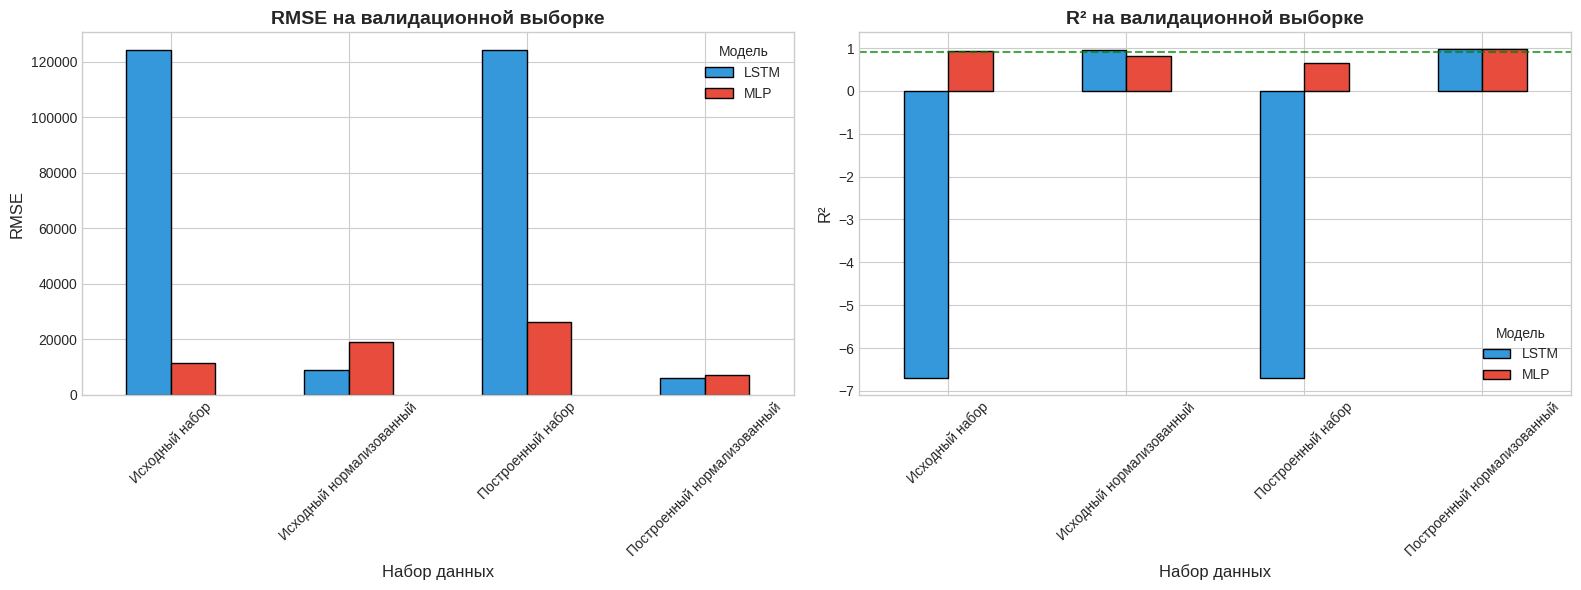

In [27]:
# Визуализация сравнения моделей
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE на валидации
pivot_rmse = results_df.pivot(index='Dataset', columns='Model', values='Val_RMSE')
pivot_rmse.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'], edgecolor='black')
axes[0].set_title('RMSE на валидационной выборке', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Набор данных', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].legend(title='Модель')
axes[0].tick_params(axis='x', rotation=45)

# R² на валидации
pivot_r2 = results_df.pivot(index='Dataset', columns='Model', values='Val_R2')
pivot_r2.plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c'], edgecolor='black')
axes[1].set_title('R² на валидационной выборке', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Набор данных', fontsize=12)
axes[1].set_ylabel('R²', fontsize=12)
axes[1].legend(title='Модель')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='R²=0.9')

plt.tight_layout()
plt.show()

In [28]:
# Определение лучшей модели
print("=" * 60)
print("ОПРЕДЕЛЕНИЕ ЛУЧШЕЙ МОДЕЛИ")
print("=" * 60)

# Лучшая по R² на валидации
best_idx = results_df['Val_R2'].idxmax()
best_result = results_df.loc[best_idx]

print(f"\n✓ Лучшая модель по R² на валидации:")
print(f"  Набор данных: {best_result['Dataset']}")
print(f"  Модель: {best_result['Model']}")
print(f"  Val R²: {best_result['Val_R2']:.4f}")
print(f"  Val RMSE: {best_result['Val_RMSE']:.2f}")

# Ключ лучшей модели
best_dataset_key = None
for key, data in data_splits.items():
    if data['name'] == best_result['Dataset']:
        best_dataset_key = key
        break

best_model_key = f"{best_dataset_key}_{best_result['Model']}"
print(f"\n  Ключ лучшей модели: {best_model_key}")

ОПРЕДЕЛЕНИЕ ЛУЧШЕЙ МОДЕЛИ

✓ Лучшая модель по R² на валидации:
  Набор данных: Построенный нормализованный
  Модель: LSTM
  Val R²: 0.9819
  Val RMSE: 6025.67

  Ключ лучшей модели: selected_normalized_LSTM


## 6. Оценка лучшей модели на тестовом наборе

In [29]:
# Оценка лучшей модели на тесте
print("=" * 60)
print("ОЦЕНКА ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОМ НАБОРЕ")
print("=" * 60)

best_model_info = models_dict[best_model_key]
best_model = best_model_info['model']
is_normalized = best_model_info['is_normalized']

# Данные для теста
X_test = data_splits[best_dataset_key]['X_test']
y_test = data_splits[best_dataset_key]['y_test']

# Преобразование для LSTM
if best_result['Model'] == 'LSTM':
    X_test_model = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
else:
    X_test_model = X_test

# Предсказание
y_test_pred = best_model.predict(X_test_model, verbose=0).flatten()

# Метрики
scaler = scaler_y if is_normalized else None
test_metrics = calculate_metrics(y_test, y_test_pred, scaler)

print(f"\nМетрики на тестовой выборке:")
print(f"  RMSE: {test_metrics['RMSE']:.2f}")
print(f"  R²:   {test_metrics['R2']:.4f}")
print(f"  MAE:  {test_metrics['MAE']:.2f}")

ОЦЕНКА ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОМ НАБОРЕ

Метрики на тестовой выборке:
  RMSE: 10294.58
  R²:   0.8691
  MAE:  8504.88


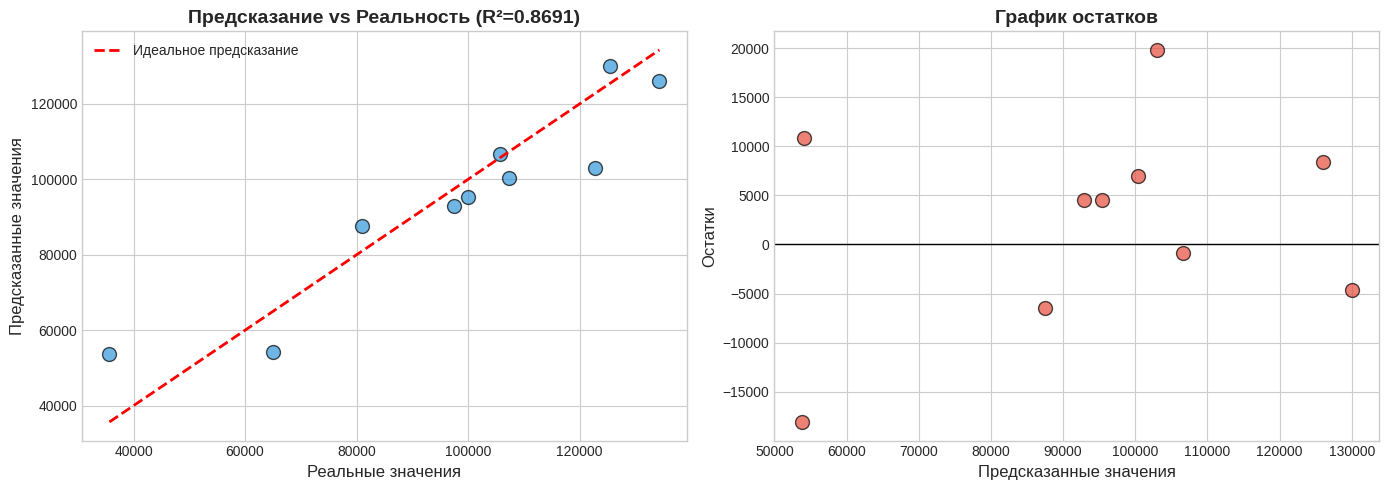

In [30]:
# Визуализация предсказаний на тесте
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Обратное преобразование для отображения реальных значений
if is_normalized:
    y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_real = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
else:
    y_test_real = y_test
    y_pred_real = y_test_pred

# График предсказания vs реальные значения
axes[0].scatter(y_test_real, y_pred_real, alpha=0.7, s=100, edgecolor='black', c='#3498db')
min_val = min(y_test_real.min(), y_pred_real.min())
max_val = max(y_test_real.max(), y_pred_real.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Идеальное предсказание')
axes[0].set_xlabel('Реальные значения', fontsize=12)
axes[0].set_ylabel('Предсказанные значения', fontsize=12)
axes[0].set_title(f'Предсказание vs Реальность (R²={test_metrics["R2"]:.4f})', fontsize=14, fontweight='bold')
axes[0].legend()

# График остатков
residuals = y_test_real - y_pred_real
axes[1].scatter(y_pred_real, residuals, alpha=0.7, s=100, edgecolor='black', c='#e74c3c')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Предсказанные значения', fontsize=12)
axes[1].set_ylabel('Остатки', fontsize=12)
axes[1].set_title('График остатков', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Grid Search для лучшей модели

In [31]:
# Grid Search для поиска лучших гиперпараметров
print("=" * 60)
print("GRID SEARCH ДЛЯ ЛУЧШЕЙ МОДЕЛИ")
print("=" * 60)

# Данные для Grid Search (объединяем train и val)
X_train_gs = data_splits[best_dataset_key]['X_train']
X_val_gs = data_splits[best_dataset_key]['X_val']
y_train_gs = data_splits[best_dataset_key]['y_train']
y_val_gs = data_splits[best_dataset_key]['y_val']

X_train_full = np.vstack([X_train_gs, X_val_gs])
y_train_full = np.concatenate([y_train_gs, y_val_gs])

print(f"\nРазмер данных для Grid Search: {X_train_full.shape}")

# Определение функции создания модели для KerasRegressor
input_dim_gs = X_train_full.shape[1]

if best_result['Model'] == 'MLP':
    def create_model_gs(neurons=64, learning_rate=0.001):
        return create_mlp_model(input_dim_gs, neurons=neurons, learning_rate=learning_rate)

    X_train_gs_model = X_train_full
else:  # LSTM
    def create_model_gs(units=64, learning_rate=0.001):
        return create_lstm_model(input_dim_gs, units=units, learning_rate=learning_rate)

    X_train_gs_model = X_train_full.reshape((X_train_full.shape[0], 1, X_train_full.shape[1]))

GRID SEARCH ДЛЯ ЛУЧШЕЙ МОДЕЛИ

Размер данных для Grid Search: (40, 2)


In [32]:
# Параметры для Grid Search
if best_result['Model'] == 'MLP':
    param_grid = {
        'model__neurons': [32, 64, 128],
        'model__learning_rate': [0.001, 0.01],
        'batch_size': [4, 8],
        'epochs': [100, 150]
    }
else:  # LSTM
    param_grid = {
        'model__units': [32, 64, 128],
        'model__learning_rate': [0.001, 0.01],
        'batch_size': [4, 8],
        'epochs': [100, 150]
    }

print(f"\nПараметры для поиска:")
for key, values in param_grid.items():
    print(f"  {key}: {values}")

print(f"\nОбщее количество комбинаций: {np.prod([len(v) for v in param_grid.values()])}")


Параметры для поиска:
  model__units: [32, 64, 128]
  model__learning_rate: [0.001, 0.01]
  batch_size: [4, 8]
  epochs: [100, 150]

Общее количество комбинаций: 24


In [33]:
# Ручной Grid Search (из-за несовместимости версий scikeras и sklearn)
print("\nВыполнение Grid Search (это может занять несколько минут)...")

from sklearn.model_selection import KFold

# Параметры для перебора
if best_result['Model'] == 'MLP':
    param_combinations = [
        {'neurons': n, 'learning_rate': lr, 'batch_size': bs, 'epochs': ep}
        for n in [32, 64, 128]
        for lr in [0.001, 0.01]
        for bs in [4, 8]
        for ep in [100, 150]
    ]
else:  # LSTM
    param_combinations = [
        {'units': u, 'learning_rate': lr, 'batch_size': bs, 'epochs': ep}
        for u in [32, 64, 128]
        for lr in [0.001, 0.01]
        for bs in [4, 8]
        for ep in [100, 150]
    ]

print(f"Всего комбинаций: {len(param_combinations)}")

# Кросс-валидация
kfold = KFold(n_splits=3, shuffle=True, random_state=SEED)
grid_results = []

for i, params in enumerate(param_combinations):
    fold_scores = []

    for train_idx, val_idx in kfold.split(X_train_full):
        X_tr, X_vl = X_train_full[train_idx], X_train_full[val_idx]
        y_tr, y_vl = y_train_full[train_idx], y_train_full[val_idx]

        # Создание модели
        if best_result['Model'] == 'MLP':
            model = create_mlp_model(input_dim_gs, neurons=params['neurons'],
                                      learning_rate=params['learning_rate'])
            X_tr_m, X_vl_m = X_tr, X_vl
        else:
            model = create_lstm_model(input_dim_gs, units=params['units'],
                                       learning_rate=params['learning_rate'])
            X_tr_m = X_tr.reshape((X_tr.shape[0], 1, X_tr.shape[1]))
            X_vl_m = X_vl.reshape((X_vl.shape[0], 1, X_vl.shape[1]))

        # Обучение
        early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
        model.fit(X_tr_m, y_tr, validation_data=(X_vl_m, y_vl),
                  epochs=params['epochs'], batch_size=params['batch_size'],
                  callbacks=[early_stop], verbose=0)

        # Оценка
        y_pred = model.predict(X_vl_m, verbose=0).flatten()
        mse = mean_squared_error(y_vl, y_pred)
        fold_scores.append(mse)

    mean_mse = np.mean(fold_scores)
    grid_results.append({'params': params, 'mean_mse': mean_mse, 'std_mse': np.std(fold_scores)})

    if (i + 1) % 6 == 0:
        print(f"  Прогресс: {i+1}/{len(param_combinations)} комбинаций...")

# Лучшие параметры
grid_results_df = pd.DataFrame(grid_results)
best_grid_idx = grid_results_df['mean_mse'].idxmin()
best_params = grid_results_df.loc[best_grid_idx, 'params']
best_score = -grid_results_df.loc[best_grid_idx, 'mean_mse']

print("\n" + "="*60)
print("✓ Grid Search завершен!")
print("="*60)


Выполнение Grid Search (это может занять несколько минут)...
Всего комбинаций: 24
  Прогресс: 6/24 комбинаций...
  Прогресс: 12/24 комбинаций...
  Прогресс: 18/24 комбинаций...
  Прогресс: 24/24 комбинаций...

✓ Grid Search завершен!


In [34]:
# Результаты Grid Search
print("=" * 60)
print("РЕЗУЛЬТАТЫ GRID SEARCH")
print("=" * 60)

print(f"\nЛучшие гиперпараметры:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

best_rmse_cv = np.sqrt(grid_results_df.loc[best_grid_idx, 'mean_mse'])
print(f"\nЛучший RMSE (кросс-валидация): {best_rmse_cv:.2f}")

# Топ-5 комбинаций параметров
print("\nТоп-5 комбинаций параметров:")
grid_results_df['RMSE'] = np.sqrt(grid_results_df['mean_mse'])
top5 = grid_results_df.nsmallest(5, 'RMSE')[['params', 'RMSE', 'std_mse']]
for idx, row in top5.iterrows():
    print(f"  RMSE: {row['RMSE']:.2f} | Params: {row['params']}")

РЕЗУЛЬТАТЫ GRID SEARCH

Лучшие гиперпараметры:
  units: 64
  learning_rate: 0.01
  batch_size: 4
  epochs: 150

Лучший RMSE (кросс-валидация): 0.05

Топ-5 комбинаций параметров:
  RMSE: 0.05 | Params: {'units': 64, 'learning_rate': 0.01, 'batch_size': 4, 'epochs': 150}
  RMSE: 0.05 | Params: {'units': 64, 'learning_rate': 0.01, 'batch_size': 4, 'epochs': 100}
  RMSE: 0.05 | Params: {'units': 32, 'learning_rate': 0.01, 'batch_size': 8, 'epochs': 100}
  RMSE: 0.05 | Params: {'units': 128, 'learning_rate': 0.01, 'batch_size': 4, 'epochs': 100}
  RMSE: 0.05 | Params: {'units': 32, 'learning_rate': 0.01, 'batch_size': 4, 'epochs': 150}


## 8. Оценка модели после Grid Search на тестовом наборе

In [35]:
# Обучение модели с лучшими параметрами на полных данных
print("=" * 60)
print("ОБУЧЕНИЕ МОДЕЛИ С ЛУЧШИМИ ГИПЕРПАРАМЕТРАМИ")
print("=" * 60)

# Извлечение параметров (best_params уже определён в предыдущей ячейке)
if best_result['Model'] == 'MLP':
    neurons = best_params.get('neurons', 64)
    learning_rate = best_params.get('learning_rate', 0.001)
    best_optimized_model = create_mlp_model(input_dim_gs, neurons=neurons, learning_rate=learning_rate)
else:
    units = best_params.get('units', 64)
    learning_rate = best_params.get('learning_rate', 0.001)
    best_optimized_model = create_lstm_model(input_dim_gs, units=units, learning_rate=learning_rate)

batch_size = best_params.get('batch_size', 8)
epochs = best_params.get('epochs', 100)

# Early Stopping
early_stop = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True, verbose=0)

# Обучение
print(f"\nОбучение с параметрами: batch_size={batch_size}, epochs={epochs}")
history_optimized = best_optimized_model.fit(
    X_train_gs_model, y_train_full,
    epochs=epochs, batch_size=batch_size,
    callbacks=[early_stop], verbose=0
)

print(f"✓ Обучение завершено за {len(history_optimized.history['loss'])} эпох")

ОБУЧЕНИЕ МОДЕЛИ С ЛУЧШИМИ ГИПЕРПАРАМЕТРАМИ

Обучение с параметрами: batch_size=4, epochs=150
✓ Обучение завершено за 91 эпох


In [36]:
# Оценка на тестовом наборе
print("=" * 60)
print("ОЦЕНКА ОПТИМИЗИРОВАННОЙ МОДЕЛИ НА ТЕСТОВОМ НАБОРЕ")
print("=" * 60)

# Подготовка тестовых данных
if best_result['Model'] == 'LSTM':
    X_test_opt = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
else:
    X_test_opt = X_test

# Предсказание
y_test_pred_opt = best_optimized_model.predict(X_test_opt, verbose=0).flatten()

# Метрики
test_metrics_opt = calculate_metrics(y_test, y_test_pred_opt, scaler)

print(f"\nМетрики оптимизированной модели на тесте:")
print(f"  RMSE: {test_metrics_opt['RMSE']:.2f}")
print(f"  R²:   {test_metrics_opt['R2']:.4f}")
print(f"  MAE:  {test_metrics_opt['MAE']:.2f}")

ОЦЕНКА ОПТИМИЗИРОВАННОЙ МОДЕЛИ НА ТЕСТОВОМ НАБОРЕ

Метрики оптимизированной модели на тесте:
  RMSE: 10324.36
  R²:   0.8684
  MAE:  6767.02


In [37]:
# Сравнение до и после Grid Search
print("=" * 60)
print("СРАВНЕНИЕ МОДЕЛИ ДО И ПОСЛЕ GRID SEARCH")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Метрика': ['RMSE', 'R²', 'MAE'],
    'До оптимизации': [test_metrics['RMSE'], test_metrics['R2'], test_metrics['MAE']],
    'После оптимизации': [test_metrics_opt['RMSE'], test_metrics_opt['R2'], test_metrics_opt['MAE']],
    'Изменение': [
        f"{((test_metrics_opt['RMSE'] - test_metrics['RMSE']) / test_metrics['RMSE'] * 100):+.2f}%",
        f"{((test_metrics_opt['R2'] - test_metrics['R2']) / abs(test_metrics['R2']) * 100):+.2f}%" if test_metrics['R2'] != 0 else "N/A",
        f"{((test_metrics_opt['MAE'] - test_metrics['MAE']) / test_metrics['MAE'] * 100):+.2f}%"
    ]
})

print(comparison_df.to_string(index=False))

СРАВНЕНИЕ МОДЕЛИ ДО И ПОСЛЕ GRID SEARCH
Метрика  До оптимизации  После оптимизации Изменение
   RMSE    10294.583430       10324.362256    +0.29%
     R²        0.869129           0.868371    -0.09%
    MAE     8504.875000        6767.018555   -20.43%


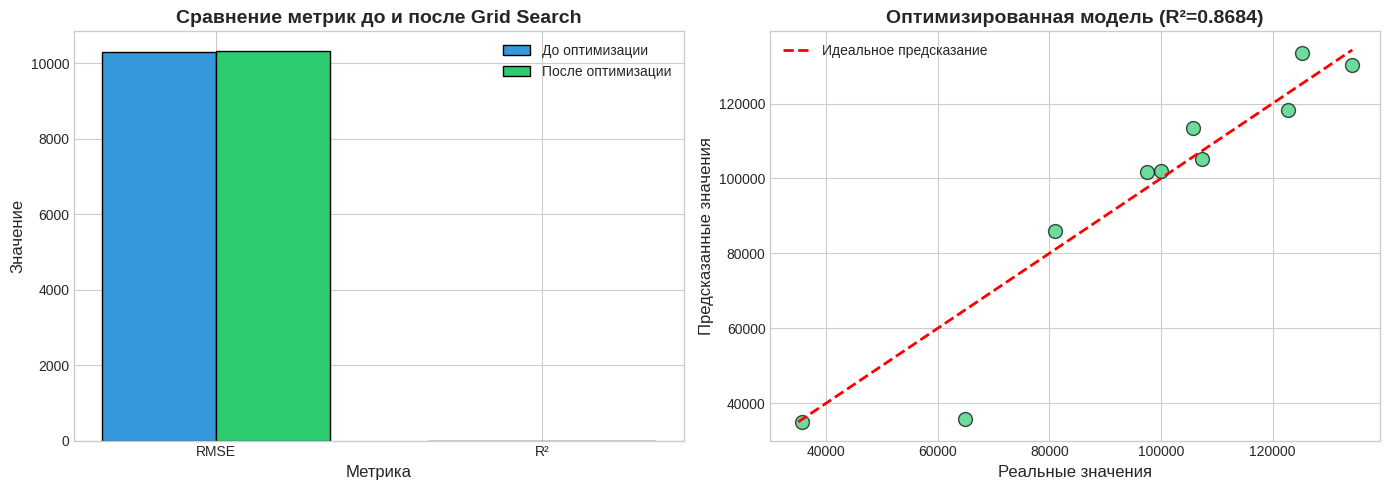

In [38]:
# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Сравнение RMSE и R²
metrics_names = ['RMSE', 'R²']
before_values = [test_metrics['RMSE'], test_metrics['R2']]
after_values = [test_metrics_opt['RMSE'], test_metrics_opt['R2']]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = axes[0].bar(x - width/2, before_values, width, label='До оптимизации', color='#3498db', edgecolor='black')
bars2 = axes[0].bar(x + width/2, after_values, width, label='После оптимизации', color='#2ecc71', edgecolor='black')

axes[0].set_xlabel('Метрика', fontsize=12)
axes[0].set_ylabel('Значение', fontsize=12)
axes[0].set_title('Сравнение метрик до и после Grid Search', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend()

# Визуализация предсказаний оптимизированной модели
if is_normalized:
    y_test_real_opt = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_real_opt = scaler_y.inverse_transform(y_test_pred_opt.reshape(-1, 1)).flatten()
else:
    y_test_real_opt = y_test
    y_pred_real_opt = y_test_pred_opt

axes[1].scatter(y_test_real_opt, y_pred_real_opt, alpha=0.7, s=100, edgecolor='black', c='#2ecc71')
min_val = min(y_test_real_opt.min(), y_pred_real_opt.min())
max_val = max(y_test_real_opt.max(), y_pred_real_opt.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Идеальное предсказание')
axes[1].set_xlabel('Реальные значения', fontsize=12)
axes[1].set_ylabel('Предсказанные значения', fontsize=12)
axes[1].set_title(f'Оптимизированная модель (R²={test_metrics_opt["R2"]:.4f})', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 9. Выводы

In [39]:
# Итоговые выводы
print("=" * 80)
print("ВЫВОДЫ ПО ПРОВЕДЕННОМУ АНАЛИЗУ")
print("=" * 80)

print("""
1. АНАЛИЗ ДАННЫХ:
   • Датасет содержит 50 записей о стартапах с 5 признаками
   • Пропущенные значения и дубликаты отсутствуют
   • Категориальный признак State (3 значения) закодирован One-Hot Encoding

2. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:
   • R&D Spend имеет очень сильную корреляцию с Profit (0.973)
   • Marketing Spend имеет умеренную корреляцию (0.748)
   • Administration имеет слабую корреляцию (0.201)
   • Для построенного набора отобраны: R&D Spend, Marketing Spend

3. СРАВНЕНИЕ МОДЕЛЕЙ:""")

print(f"   • Лучшая модель: {best_result['Model']} на наборе '{best_result['Dataset']}'")
print(f"   • R² на валидации: {best_result['Val_R2']:.4f}")
print(f"   • RMSE на валидации: {best_result['Val_RMSE']:.2f}")

print(f"""
4. РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ (до оптимизации):
   • R²: {test_metrics['R2']:.4f}
   • RMSE: {test_metrics['RMSE']:.2f}
   • MAE: {test_metrics['MAE']:.2f}

5. GRID SEARCH:
   • Лучшие гиперпараметры: {best_params}

6. РЕЗУЛЬТАТЫ ПОСЛЕ ОПТИМИЗАЦИИ:
   • R²: {test_metrics_opt['R2']:.4f}
   • RMSE: {test_metrics_opt['RMSE']:.2f}
   • MAE: {test_metrics_opt['MAE']:.2f}

7. ОБЩИЕ ВЫВОДЫ:
   • Нейросетевые модели успешно решают задачу регрессии на данном наборе
   • Нормализация данных улучшает качество обучения нейросетей
   • R&D Spend является ключевым фактором прибыли стартапа
   • Grid Search позволяет найти оптимальные гиперпараметры модели
   • Полносвязная сеть (MLP) и LSTM показывают сопоставимые результаты
     на данных небольшого размера
""")

print("=" * 80)
print("ЛАБОРАТОРНАЯ РАБОТА №1 ВЫПОЛНЕНА")
print("Вариант 3: LSTM + Нормализация")
print("=" * 80)

ВЫВОДЫ ПО ПРОВЕДЕННОМУ АНАЛИЗУ

1. АНАЛИЗ ДАННЫХ:
   • Датасет содержит 50 записей о стартапах с 5 признаками
   • Пропущенные значения и дубликаты отсутствуют
   • Категориальный признак State (3 значения) закодирован One-Hot Encoding

2. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:
   • R&D Spend имеет очень сильную корреляцию с Profit (0.973)
   • Marketing Spend имеет умеренную корреляцию (0.748)
   • Administration имеет слабую корреляцию (0.201)
   • Для построенного набора отобраны: R&D Spend, Marketing Spend

3. СРАВНЕНИЕ МОДЕЛЕЙ:
   • Лучшая модель: LSTM на наборе 'Построенный нормализованный'
   • R² на валидации: 0.9819
   • RMSE на валидации: 6025.67

4. РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ (до оптимизации):
   • R²: 0.8691
   • RMSE: 10294.58
   • MAE: 8504.88

5. GRID SEARCH:
   • Лучшие гиперпараметры: {'units': 64, 'learning_rate': 0.01, 'batch_size': 4, 'epochs': 150}

6. РЕЗУЛЬТАТЫ ПОСЛЕ ОПТИМИЗАЦИИ:
   • R²: 0.8684
   • RMSE: 10324.36
   • MAE: 6767.02

7. ОБЩИЕ ВЫВОДЫ:
   • Нейросетевые модели

In [40]:
# Финальная сводная таблица всех экспериментов
print("\nФИНАЛЬНАЯ СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)


ФИНАЛЬНАЯ СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:
                    Dataset Model  Train_RMSE  Train_R2    Val_RMSE  Val_R2  Epochs
             Исходный набор   MLP  25119.4369    0.6120  11415.1433  0.9351      25
             Исходный набор  LSTM 121913.1379   -8.1405 124385.1032 -6.7089     200
   Исходный нормализованный   MLP  28766.3581    0.4911  18987.0364  0.8204      27
   Исходный нормализованный  LSTM  10671.7515    0.9300   8898.7199  0.9605      70
          Построенный набор   MLP  24218.6929    0.6393  26310.9212  0.6551      61
          Построенный набор  LSTM 121928.2979   -8.1427 124392.0841 -6.7097     200
Построенный нормализованный   MLP  10996.1331    0.9256   7073.5075  0.9751      45
Построенный нормализованный  LSTM  11948.3060    0.9122   6025.6661  0.9819      70
